U.S Housing Price Forecasting For College Students Using Data Mining Techniques

- **Dataset Source**: Airbnb_Texas_Rental.cvs

In [ ]:
!pip install pyspark
!pip install graphframes
!pip install -U -q PyDrive
!apt install openjdk-8-jdk-headless -qq
!curl -L -o "/usr/local/lib/python3.7/dist-packages/pyspark/jars/graphframes-0.8.1-spark3.0-s_2.12.jar" https://repos.spark-packages.org/graphframes/graphframes/0.8.1-spark3.0-s_2.12/graphframes-0.8.1-spark3.0-s_2.12.jar
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

     |████████████████████████████████| 281.3 MB 38 kB/s 
     |████████████████████████████████| 198 kB 62.4 MB/s 
  Created wheel for pyspark: filename=pyspark-3.2.0-py2.py3-none-any.whl size=281805912 sha256=a14f40937aa36bf74e7157c85a88cad09dba5d86609b55d80f9e692a074da635
  Stored in directory: /root/.cache/pip/wheels/0b/de/d2/9be5d59d7331c6c2a7c1b6d1a4f463ce107332b1ecd4e80718
Successfully built pyspark
     |████████████████████████████████| 154 kB 5.1 MB/s 
The following additional packages will be installed:
  openjdk-8-jre-headless
Suggested packages:
  openjdk-8-demo openjdk-8-source libnss-mdns fonts-dejavu-extra
  fonts-ipafont-gothic fonts-ipafont-mincho fonts-wqy-microhei
  fonts-wqy-zenhei fonts-indic
The following NEW packages will be installed:
  openjdk-8-jdk-headless openjdk-8-jre-headless
0 upgraded, 2 newly installed, 0 to remove and 37 not upgraded.
Need to get 36.5 MB of archives.
After this operation, 143 MB of additional disk space will be used.
Selecting previou

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import pyspark
from pyspark.sql import *
from pyspark.sql.types import *
from pyspark import SparkContext, SparkConf

In [ ]:
# create the session
conf = SparkConf().set("spark.ui.port", "4050")

# SUBMIT_ARGS = "--packages graphframes:graphframes:0.8.0-spark2.4-s_2.12 pyspark-shell"
# os.environ["PYSPARK_SUBMIT_ARGS"] = SUBMIT_ARGS

# create the context
sc = pyspark.SparkContext(conf=conf)
# spark = SparkSession.builder.getOrCreate()
spark = SparkSession.builder.getOrCreate()

In [ ]:
get_ipython().system_raw('./ngrok http 4050 &')
!./ngrok authtoken 
!curl -s http://localhost:4040/api/tunnels | python3 -c "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

/bin/bash: ./ngrok: No such file or directory
Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/usr/lib/python3.7/json/__init__.py", line 296, in load
    parse_constant=parse_constant, object_pairs_hook=object_pairs_hook, **kw)
  File "/usr/lib/python3.7/json/__init__.py", line 348, in loads
    return _default_decoder.decode(s)
  File "/usr/lib/python3.7/json/decoder.py", line 337, in decode
    obj, end = self.raw_decode(s, idx=_w(s, 0).end())
  File "/usr/lib/python3.7/json/decoder.py", line 355, in raw_decode
    raise JSONDecodeError("Expecting value", s, err.value) from None
json.decoder.JSONDecodeError: Expecting value: line 1 column 1 (char 0)


In [ ]:
# Load the Airbnb_Texas_Rental Dataset 

texas_rentals = spark.read.csv("Airbnb_Texas_Rentals.csv", header=True)
texas_rentals.show()

+---+----------------------+--------------+--------------+---------------+--------------------+--------------------+-----------------+--------------------+--------------------+
|_c0|average_rate_per_night|bedrooms_count|          city|date_of_listing|         description|            latitude|        longitude|               title|                 url|
+---+----------------------+--------------+--------------+---------------+--------------------+--------------------+-----------------+--------------------+--------------------+
|  1|                   $27|             2|        Humble|       May 2016|Welcome to stay i...|    30.0201379199512|-95.2939960042513|2 Private rooms/b...|https://www.airbn...|
|  2|                  $149|             4|   San Antonio|  November 2010|Stylish, fully re...|    29.5030676756061|-98.4476879378504|Unique Location! ...|https://www.airbn...|
|  3|                   $59|             1|       Houston|   January 2017|'River house on i...|    29.8293522272149

In [ ]:
from pyspark.sql.types import *
import pyspark.sql.functions as F

from pyspark.ml.feature import CountVectorizer, StopWordsRemover, Tokenizer
from pyspark.sql.functions import col, trim, lower, regexp_replace, explode, split, length
from pyspark.sql import Row

In [ ]:
user_tweets = texas_rentals.groupby("_c0").agg(F.concat_ws("", F.collect_list("description")).alias("description"))
user_tweets.show(10)

+-----+--------------------+
|  _c0|         description|
+-----+--------------------+
|  100|"Lovely guest sui...|
| 1000|**Will give disco...|
|10000|One queen size be...|
|10001|The peaceful priv...|
|10002|Lovely quiet neig...|
|10003|GVV Retreat is lo...|
|10009|"",30.17061901522...|
|10010|About the Locatio...|
|10011|This apartment is...|
|10012|We are just 2 min...|
+-----+--------------------+
only showing top 10 rows



In [ ]:
# Function to remove punctuations
def removePunctuation(column):
    return trim(lower(regexp_replace(column, '[^\s@a-zA-Z0-9]', ''))).alias("description")

# Remove punctuation marks from the tweets
user_document = user_tweets.select("_c0", removePunctuation(col("description")))

user_document.show(10)
# Tokenize to obtain words from tweets
tokenizer = Tokenizer(inputCol="description", outputCol="words")
wordsDataFrame = tokenizer.transform(user_document)

wordsDataFrame.show(10)
# Remove stopwords
remover = StopWordsRemover(inputCol="words", outputCol="filtered")
wordsDataFrame = remover.transform(wordsDataFrame)

wordsDataFrame.show(10)

+-----+--------------------+
|  _c0|         description|
+-----+--------------------+
|  100|lovely guest suit...|
| 1000|will give discoun...|
|10000|one queen size be...|
|10001|the peaceful priv...|
|10002|lovely quiet neig...|
|10003|gvv retreat is lo...|
|10009|30170619015221977...|
|10010|about the locatio...|
|10011|this apartment is...|
|10012|we are just 2 min...|
+-----+--------------------+
only showing top 10 rows

+-----+--------------------+--------------------+
|  _c0|         description|               words|
+-----+--------------------+--------------------+
|  100|lovely guest suit...|[lovely, guest, s...|
| 1000|will give discoun...|[will, give, disc...|
|10000|one queen size be...|[one, queen, size...|
|10001|the peaceful priv...|[the, peaceful, p...|
|10002|lovely quiet neig...|[lovely, quiet, n...|
|10003|gvv retreat is lo...|[gvv, retreat, is...|
|10009|30170619015221977...|[3017061901522197...|
|10010|about the locatio...|[about, the, loca...|
|10011|this apartm

In [ ]:
from pyspark.ml.feature import CountVectorizer 
from pyspark.ml.clustering import LDA 
cv = CountVectorizer(inputCol="filtered", outputCol="features").fit(wordsDataFrame)
user_text_tweets = cv.transform(wordsDataFrame)
user_text_tweets.show(10)

#creating LDA model 
lda_model = LDA(k=4)
topics = lda_model.fit(user_text_tweets).describeTopics(10)
topics.show()

+-----+--------------------+--------------------+--------------------+--------------------+
|  _c0|         description|               words|            filtered|            features|
+-----+--------------------+--------------------+--------------------+--------------------+
|  100|lovely guest suit...|[lovely, guest, s...|[lovely, guest, s...|(23061,[0,12,47,8...|
| 1000|will give discoun...|[will, give, disc...|[give, discount, ...|(23061,[0,4,14,15...|
|10000|one queen size be...|[one, queen, size...|[one, queen, size...|(23061,[1,2,3,5,6...|
|10001|the peaceful priv...|[the, peaceful, p...|[peaceful, privat...|(23061,[1,3,4,5,6...|
|10002|lovely quiet neig...|[lovely, quiet, n...|[lovely, quiet, n...|(23061,[2,6,8,13,...|
|10003|gvv retreat is lo...|[gvv, retreat, is...|[gvv, retreat, lo...|(23061,[4,7,22,28...|
|10009|30170619015221977...|[3017061901522197...|[3017061901522197...|(23061,[197,14793...|
|10010|about the locatio...|[about, the, loca...|[location, locati...|(23061,[0,

/usr/local/lib/python3.7/dist-packages/pyspark/sql/context.py:127: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


Topic 0
Words ['place', 'home', 'downtown', 'minutes', 'close', 'located', 'private', 'amp', 'house', 'restaurants']



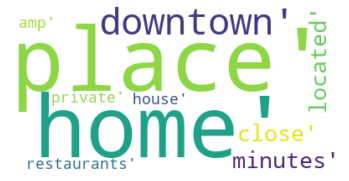

Topic 1
Words ['place', 'hill', 'acres', 'country', 'away', 'amp', 'river', 'lake', 'texas']



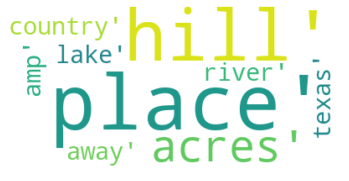

Topic 2
Words ['room', 'bed', '2', 'bedroom', 'private', 'kitchen', 'full', 'queen', 'living', 'home']



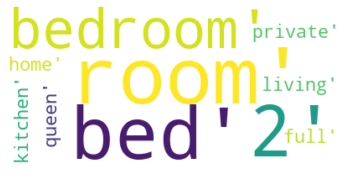

Topic 3
Words ['dates', 'amp', 'resort', 'guests', 'refundable', 'deposit', 'credit', 'card', 'fees', 'requires']



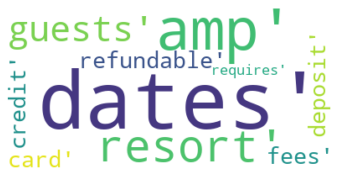

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud

vocabArray = cv.vocabulary 

def customFunction(row):
    topic = row.topic
    terms = row.termIndices
    words = []
    c = 0
    for i in terms:
        if vocabArray[i] != '':
            words.append(vocabArray[i])
            c = c + 1
            if c == 10:
                break
    return (topic, words)

sample2 = topics.rdd.map(customFunction)

for i in sample2.collect():
    print("Topic", i[0])
    text = str(i)
    # print(type(text))
    print("Words", i[1])
    print()
    wordcloud = WordCloud(collocations = False, background_color = 'white').generate(text)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()
